# ASSIGNMENT - 2
## Applied Natural Language Processing
#### Name : Sheni Nevil
#### Student ID : a1911961

### DATASET COLLECTION

In [ ]:
# Install stackapi if not installed before
#pip install stackapi

In [ ]:
# Dataset Collection

# Import required libraries
import os
import time
import requests
import pandas as pd
from tqdm import tqdm


# Configuration parameters
# Stack exchange api key
api_key = 'MY_API_KEY'
# The stack exchange site to query
site = 'stackoverflow'
# The tag to filter questions by
tag = 'nlp'
# First page number 
start_page = 1
# Number of questions per api request
page_size = 100
# Maximum number of pages to be fetch
max_pages = 200000
# Delay (in seconds) between api calls to avoid api rate limits
delay = 0.7

# Output csv filename
csv_file = 'stack_nlp_combined.csv'


# The function fetches a page of questions tagged with tag from the stack exchange API and returns the parsed JSON response or an error
def fetch_questions(page):
    url = 'https://api.stackexchange.com/2.3/questions'
    # Here sort by votes to get popular questions first and filter to include question body in the response
    parameters1 = {'page':page,'pagesize':page_size,'order':'desc','sort':'votes','tagged':tag,'site':site,'filter':'withbody','key':api_key}
    print(f"Requesting page {page}")
    
    try:
        response = requests.get(url,params=parameters1)
        # Adding a pause to avoid hitting API rate limits
        time.sleep(delay)
        
        # Checking and handling non-200 response/http errors
        if response.status_code != 200:
            print(f"API returned status code {response.status_code}")
            print(f"Response body : {response.text[:200]}")
            return {}

        # Returning JSON payload
        return response.json()
        
    except requests.exceptions.JSONDecodeError as e:
        # JSON parsing error
        print(f"Failed to parse JSON : {e}")
        print(f"Raw response text : {response.text[:200]}")
        return {}
        
    except Exception as e:
        # Other request related errors
        print(f"Exception while requesting page {page} : {e}")
        return {}


# The function fetches accepted answer body and returns the answer body as a string or empty string for errors
def fetch_answer(answer_id):
    url = f'https://api.stackexchange.com/2.3/answers/{answer_id}'
    parameters2 = {'site':site,'filter':'withbody','key':api_key}
    
    try:
        resp = requests.get(url,params=parameters2)
        # Adding a pause to avoid hitting API rate limits
        time.sleep(delay)
        items = resp.json().get('items', [])
        return items[0]['body'] if items else ''
        
    except Exception as e:
        print(f"Error fetching answer {answer_id} : {e}")
        return ''


# Saving records to CSV (append mode if not first, that is if is_first_page=True overwrite existing file, otherwise append to the existing file)
def save_to_csv(records,is_first_page=False):
    df = pd.DataFrame(records)
    mode = 'w' if is_first_page else 'a'
    df.to_csv(csv_file,mode=mode,index=False,header=is_first_page)
    print(f"{len(records)} records saved")


# The main driver function that iterates through pages to collect 20000 nlp tagged questions that have an accepted answer. For each qualifying question it fetches its accepted answer body and saves records incrementally to a CSV file.
def main():
    print("Starting stack overflow nlp question fetcher with only accepted answers\n")
    collected = 0
    page = start_page
    saved_1st_page = False

    # Iterating through pages until hitting the collection target or run out of pages
    while collected<20000 and page<=max_pages:
        print(f"\nPage {page}")
        data = fetch_questions(page)
        
        # Handle errors
        if 'items' not in data:
            print("API error or limit hit : ",data)
            break
        
        questions = data['items']
        records = []

        # Processing each question in the page
        for q in tqdm(questions,desc="Processing",unit="question"):
            # Skipping if no accepted answer in question
            if 'accepted_answer_id' not in q:
                continue
                
            # Fetch the accepted answer body    
            answer_body = fetch_answer(q['accepted_answer_id'])
            
            # Collecting relevant fields into our saved record
            records.append({'question_id': q.get('question_id'),'title': q.get('title'),'body': q.get('body'),'tags': ';'.join(q.get('tags',[])),'accepted_answer': answer_body})

        # Save each page's records to CSV
        if records:
            save_to_csv(records,is_first_page=not saved_1st_page)
            saved_1st_page = True
            collected += len(records)
            print(f"Total data collected so far : {collected}")
        else:
            print("No questions with accepted-answers found on this page")

        # Getting to the next page
        page += 1
        
    print(f"\nFinished collecting {collected} posts")

if __name__ == "__main__":
    main()

#### GITHUB LINK TO DATABASE : https://github.com/SheniNevil/ANLP

### DATA PRE-PROCESSING

In [ ]:
# Install wordcloud if not installed before
#pip install wordcloud

# Download NLTK resources if not downloaded before
#nltk.download('stopwords')
#nltk.download('punkt')

In [1]:
# Import required libraries
import re
import nltk
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [3]:
# Dataset file path
path = 'stack_nlp_combined.csv'

# Reading csv file to a dataframe
df = pd.read_csv(path)
print("Columns in the loaded dataset : ",df.columns.tolist())

Columns in the loaded dataset :  ['question_id', 'title', 'body', 'tags', 'accepted_answer']


In [5]:
# Summary statistics
total_questions = df['question_id'].nunique()
with_answers = df['accepted_answer'].notna().sum()
without_answers = total_questions - with_answers

print("Dataset Summary : ")
print(f"Total unique questions : {total_questions}")
print(f"Questions with answers : {with_answers}")
print(f"Questions without answers : {without_answers}")

Dataset Summary : 
Total unique questions : 20529
Questions with answers : 8530
Questions without answers : 11999


In [7]:
# Pre-processing and cleaning text data

def preprocess_text(text):
    if pd.isna(text):
        return ""
        
    # Converting to lowercase
    text = text.lower()
    # Removing punctuation and special symbols as they are non-alphanumeric characters
    text = re.sub(r'[^a-z0-9\s]',' ',text)
    # Removing URLs
    text = re.sub(r'http\S+|www\.\S+',' ',text)
    # Striping HTML tags and code snippets
    text = re.sub(r'<.*?>',' ',text)
    # Tokenizing text into words
    tokens = word_tokenize(text)
    # Removing english stopwords and single-character tokens
    stops = set(stopwords.words('english'))
    tokens = [tok for tok in tokens if tok not in stops and len(tok)>1]
    # Returning cleaned and space-joined string of tokens
    return ' '.join(tokens)


# Applying preprocessing to each of the relevant column
for col in ['title','body','accepted_answer']:
    clean_col = f"{col}_clean"
    df[clean_col] = df[col].apply(preprocess_text)
    print(f"Preprocessed '{col}' into '{clean_col}'. Sample : ")
    print(df[clean_col].head(2),"\n")

Preprocessed 'title' into 'title_clean'. Sample : 
0     google quot mean quot algorithm work
1    compute similarity two text documents
Name: title_clean, dtype: object 

Preprocessed 'body' into 'body_clean'. Sample : 
0    developing internal website portfolio manageme...
1    want take two documents determine similar prog...
Name: body_clean, dtype: object 

Preprocessed 'accepted_answer' into 'accepted_answer_clean'. Sample : 
0    explanation directly source almost h2 strong h...
1    common way transform documents tf idf vectors ...
Name: accepted_answer_clean, dtype: object 



### DATA VISUALISATION

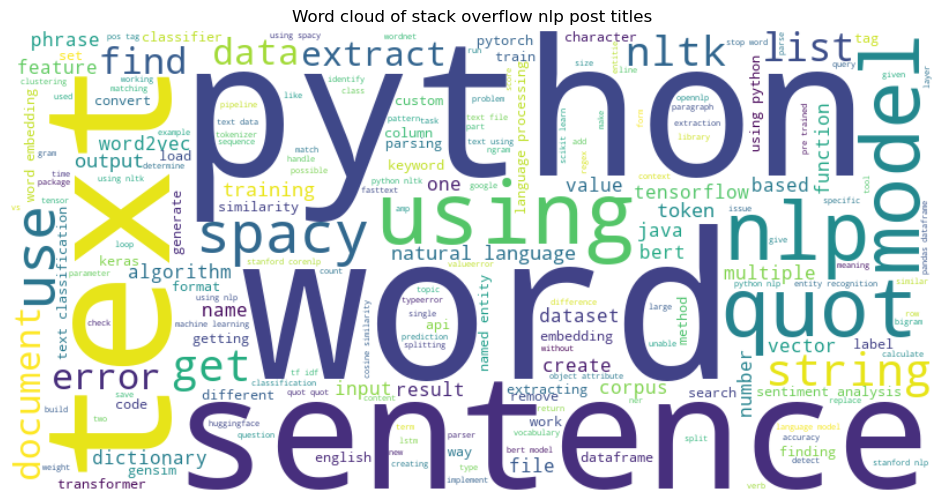

Limiting categorization to 1000 posts


In [9]:
# Graphical visualization

# Combining all cleaned titles into a large string
titles = " ".join(df['title_clean'].dropna())

# Generating the word cloud
wordcloud = WordCloud(width=800,height=400,background_color='white',stopwords=set(stopwords.words('english'))).generate(titles)

# Display the word cloud of titles
plt.figure(figsize=(12,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.title('Word cloud of stack overflow nlp post titles')
plt.show()

# Limiting dataset to first 1000 posts for categorization
df = df.head(1000).copy()
print(f"Limiting categorization to {len(df)} posts"

### DATA CATEGORIZATION

Total count of posts categorized : 1000

Count of post by category : 

category
Other               488
Task issues         260
Library specific    252
Name: count, dtype: int64 



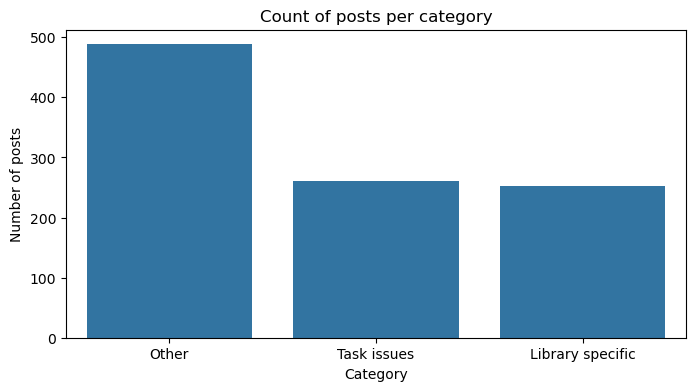

Category : Other
-> How does the Google &quot;Did you mean?&quot; Algorithm work?
-> googletrans stopped working with error &#39;NoneType&#39; object has no attribute &#39;group&#39;
-> Java Stanford NLP: Part of Speech labels?
-> Detecting syllables in a word
-> How to compute precision, recall, accuracy and f1-score for the multiclass case with scikit learn?
-> How does Apple find dates, times and addresses in emails?
-> Difference between constituency parser and dependency parser
-> What does Keras Tokenizer method exactly do?
-> How do you implement a &quot;Did you mean&quot;?
-> How can I correctly prefix a word with &quot;a&quot; and &quot;an&quot;?

Category : Task issues
-> How to compute the similarity between two text documents?
-> What is the difference between lemmatization vs stemming?
-> How to determine the language of a piece of text?
-> What does tf.nn.embedding_lookup function do?
-> Understanding min_df and max_df in scikit CountVectorizer
-> Java or Python for Natur

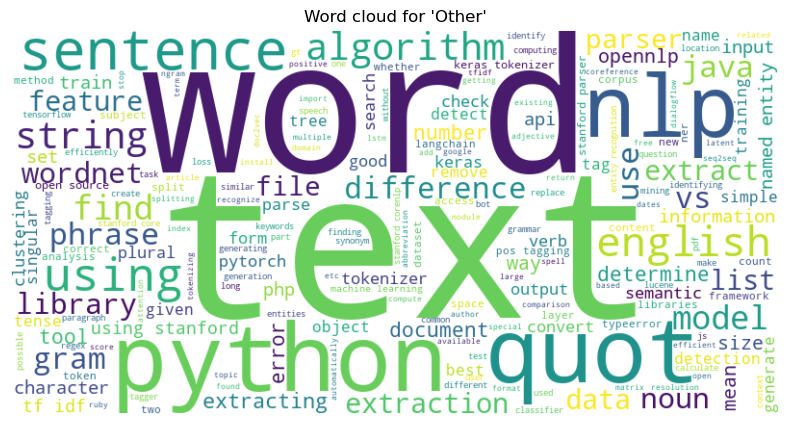

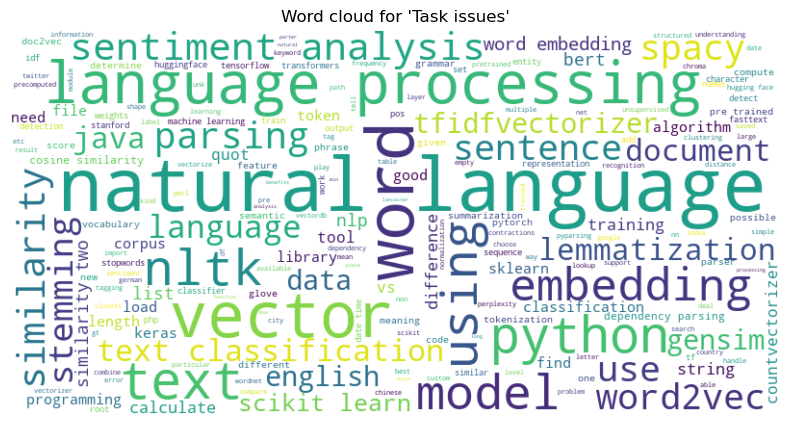

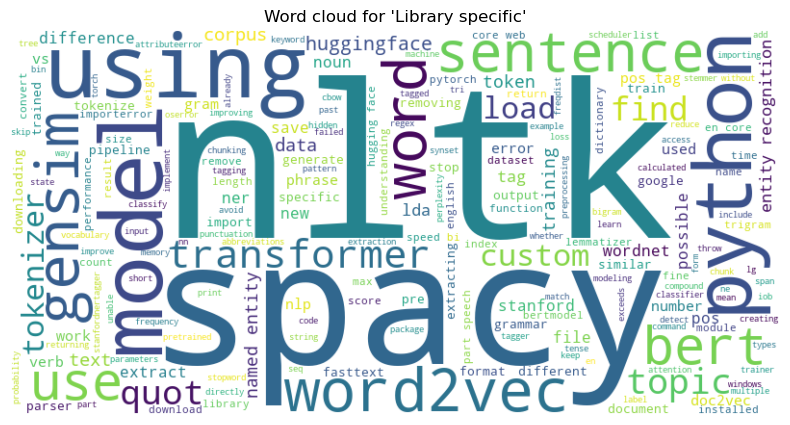

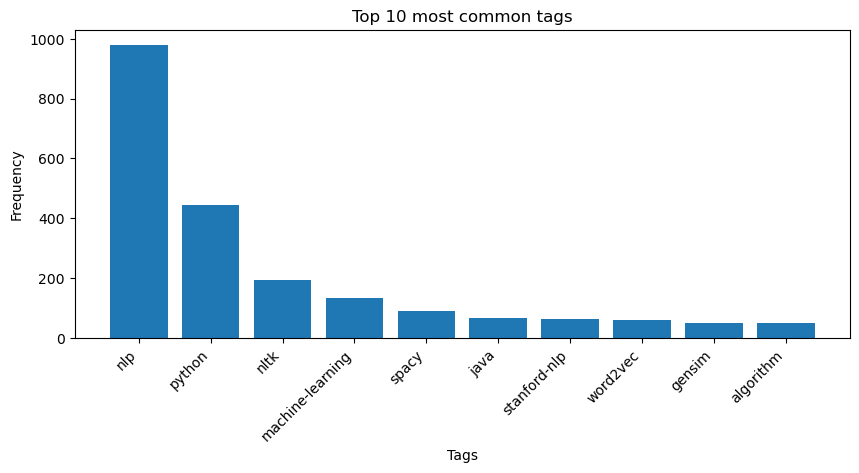

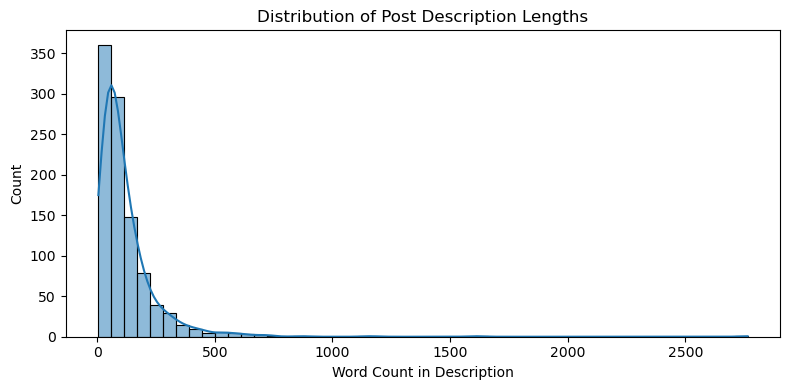

In [13]:
"""
The function below uses rule based keyword detection and here we are assigning one of 5 categories based on the title keywords :
    1. Implementation issues : if title contains 'how to' or 'how'
    2. Task issues : if title mentions specific NLP tasks
    3. Understanding issues : if title starts with 'what'
    4. Library specific : if title mentions popular NLP libraries or techniques
    5. Other : if none of the above
"""

# Categorizating the posts
def assign_category(title):
    t = title.lower()
    
    # Implementation issues
    if re.search(r'\bhow to\b|\bhow\b',t):
        return 'Implementation issues'
        
    # Task issues
    tasks = ['similarity','tokenization','stemming','lemmatization','language','classification','summarization','parsing','embedding','translation','sentiment','vector']
    if any(task in t for task in tasks):
        return 'Task issues'
        
    # Understanding issues
    if t.strip().startswith('what'):
        return 'Understanding issues'
        
    # Library specific
    libs = ['spacy','nltk','transformer','gensim','word2vec','fasttext','lda','huggingface','bert','xlm','roberta']
    if any(lib in t for lib in libs):
        return 'Library specific'
        
    # Default category
    return 'Other'


# Applying categorisation to the cleaned titles
df['category'] = df['title_clean'].apply(assign_category)

# Displaying the count of posts categorized
categorized_count = df['category'].notna().sum()
print(f"Total count of posts categorized : {categorized_count}\n")

# Displaying number of posts per category
cat_counts = df['category'].value_counts()
print("Count of post by category : \n")
print(cat_counts,"\n")


#  Plotting number of posts per category
plt.figure(figsize=(8,4))
sns.countplot(data=df,x='category',order=df['category'].value_counts().index)
plt.title("Count of posts per category")
plt.xlabel("Category")
plt.ylabel("Number of posts")
plt.show()


# Displaying few example titles from each of the post categories classified
for cat in cat_counts.index:
    eg = df[df['category'] == cat]['title'].head(10).tolist()
    print(f"Category : {cat}")
    for e in eg:
        print("->",e)
    print()


# Visual representation of word cloud per category
for cat in df['category'].unique():
    text = ' '.join(df[df['category'] == cat]['title_clean'].dropna())
    wordcloud = WordCloud(width=800,height=400,background_color='white').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word cloud for '{cat}'")
    plt.show()


# Plotting the top 10 most frequent tags
# Flattening all tags into a list
all_tags = ';'.join(df['tags'].dropna()).split(';')
tag_count = Counter(all_tags)
top_tags = tag_count.most_common(10)

tags,counts = zip(*top_tags)
plt.figure(figsize=(10,4))
plt.bar(tags,counts)
plt.title("Top 10 most common tags")
plt.xlabel("Tags")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Frequency")
plt.show()


# Plotting the distribution of post lengths (title, body andnswer)
df['title_length'] = df['title_clean'].str.split().apply(len)
df['body_length'] = df['body_clean'].str.split().apply(len)
df['answer_length'] = df['accepted_answer_clean'].str.split().apply(len)
plt.figure(figsize=(8,4))
sns.histplot(df['body_length'],bins=50,kde=True)
plt.title("Distribution of Post Description Lengths")
plt.xlabel("Word Count in Description")
plt.tight_layout()
plt.show()